**Introdução**

Construção modelo de classificação binária sobre a inadimplencia de crédito (variável Over30)

**Pacotes**

Etapa visando instalar e importar os pacotes necessários.

In [47]:
pip install pandas numpy catboost scikit-learn tensorflow imbalanced-learn xgboost lightgbm shap

In [18]:
#Tratamento de dados
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

#ML
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

#Redes Neurais
import tensorflow as tf

#Normalizacoes
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#ignorar avisos
import warnings
warnings.filterwarnings("ignore")

#Grafico
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


#api
import requests
import geopandas as gpd

**Dados**

Aqui ocorre a importação dos dados necessários.

Também foi criado um df com dummys. Há um sem dummys pois o CatBoost consegue trabalhar com variáveis categóricas sem dummy.

In [19]:
#carregar dados
df = (pd.read_excel("dados.xlsx", sheet_name="Base_Dados")
      .drop(columns=['safra','id_trx','Data compra'])
      )

#visualizar df
df.head(3)

,Hora da compra,Tipo de cliente,valor_compra,Tempo até utilização,over30_mob3,risco_validador,provedor_email,idade_cliente,Produto_1,Produto_2,Produto_3,uf,Renda,Score Email,Score Pessoa
0,17,1,1085.87,121 - 150 dias,0,Baixo Risco,hotmail,33.0,1,0,0,SP,1600.0,NaN,309.0
1,15,1,1686.34,16 - 30 dias,0,Baixo Risco,hotmail,34.0,1,0,0,SP,4250.0,85.0,322.0
2,19,1,2807.66,241 - 270 dias,0,Baixo Risco,terra,28.0,1,0,0,SP,1700.0,82.0,514.0


In [20]:
#substituir infinito e nulos
df.replace([np.inf, -np.inf], 0, inplace=True)
df['uf'].fillna("N/A", inplace=True)

df_dummy = df.fillna(df.mean())

#lista de colunas categoricas
colunas = ['Hora da compra','Tipo de cliente','Tempo até utilização','risco_validador','provedor_email','uf']

#OneHotEncoder
encoder = OneHotEncoder(sparse=False, drop='first')
df_dummy = pd.concat([df_dummy.drop(columns=colunas),pd.DataFrame(encoder.fit_transform(df_dummy[colunas]),columns=encoder.get_feature_names_out(colunas))], axis=1)

#arredondar e transformar em inteiros
df_dummy = df_dummy.round(0).astype(int)

**Análise Descritiva**

Abordando algumas das análises descritivas que foram realizadas, a fim de conhecer melhor os dados.

In [21]:
#colunas /tipos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32842 entries, 0 to 32841
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Hora da compra        32842 non-null  int64  
 1   Tipo de cliente       32842 non-null  int64  
 2   valor_compra          32842 non-null  float64
 3   Tempo até utilização  32842 non-null  object 
 4   over30_mob3           32842 non-null  int64  
 5   risco_validador       32842 non-null  object 
 6   provedor_email        32665 non-null  object 
 7   idade_cliente         32797 non-null  float64
 8   Produto_1             32842 non-null  int64  
 9   Produto_2             32842 non-null  int64  
 10  Produto_3             32842 non-null  int64  
 11  uf                    32842 non-null  object 
 12  Renda                 32673 non-null  float64
 13  Score Email           30501 non-null  float64
 14  Score Pessoa          32759 non-null  float64
dtypes: float64(5), int6

In [22]:
#estatisticas descritivas das colunas
df.describe()

,Hora da compra,Tipo de cliente,valor_compra,over30_mob3,idade_cliente,Produto_1,Produto_2,Produto_3,Renda,Score Email,Score Pessoa
count,32842.000000,32842.000000,32842.000000,32842.000000,32797.000000,32842.000000,32842.000000,32842.000000,32673.000000,30501.000000,32759.000000
mean,14.670787,1.871841,3084.378411,0.126515,35.119676,0.937610,0.323245,0.076914,7314.317632,110.927707,456.803138
std,5.713836,1.287600,3592.591868,0.332434,12.085207,0.241866,0.467722,0.266459,13559.299308,146.338165,127.186559
min,0.000000,1.000000,69.010000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,1.000000,1045.202500,0.000000,23.000000,1.000000,0.000000,0.000000,2050.000000,50.000000,367.000000
50%,15.000000,1.000000,2021.270000,0.000000,33.000000,1.000000,0.000000,0.000000,4250.000000,82.000000,458.000000
75%,19.000000,4.000000,3914.182500,0.000000,44.000000,1.000000,1.000000,0.000000,6450.000000,121.000000,550.000000
max,23.000000,4.000000,112101.750000,1.000000,88.000000,1.000000,1.000000,1.000000,360000.000000,995.000000,919.000000


In [23]:
#Contagem de Nulos. Importante para saber se será necessário algum tratamento posteriormente.
df.isna().sum()

Hora da compra             0
Tipo de cliente            0
valor_compra               0
Tempo até utilização       0
over30_mob3                0
risco_validador            0
provedor_email           177
idade_cliente             45
Produto_1                  0
Produto_2                  0
Produto_3                  0
uf                         0
Renda                    169
Score Email             2341
Score Pessoa              83
dtype: int64

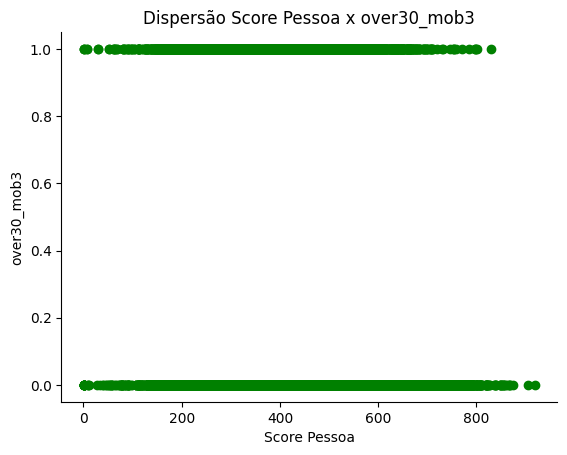

In [24]:
#Gráfico de dispersão
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.scatter(df['Score Pessoa'], df['over30_mob3'],color='green')
plt.xlabel('Score Pessoa')
plt.ylabel('over30_mob3')
plt.title('Dispersão Score Pessoa x over30_mob3')
plt.show()

In [25]:
#Avaliar algumas médias para conhecer melhor os dados
print(df.groupby('over30_mob3')['Score Pessoa'].mean())

#colunas de interesse
colunas_lista = ['Tempo até utilização', 'Tipo de cliente','risco_validador','provedor_email']

#Calculando a média para cada coluna
for coluna in colunas_lista:
    print(df.groupby(coluna)['over30_mob3'].mean())

over30_mob3
0    466.231326
1    391.807711
Name: Score Pessoa, dtype: float64
Tempo até utilização
0 -3 dias           0.107143
121 - 150 dias      0.112851
151 - 180 dias      0.124306
16 - 30 dias        0.147505
181 - 210 dias      0.154433
211 - 240 dias      0.152174
241 - 270 dias      0.155668
271 - 300 dias      0.125249
301 - 330 dias      0.128472
31 - 45 dias        0.143702
331 - 360 dias      0.062500
4 - 6 dias          0.150000
46 - 60 dias        0.138064
61 - 90 dias        0.090223
7 - 15 dias         0.147575
91 - 120 dias       0.087903
mais de 360 dias    0.200000
Name: over30_mob3, dtype: float64
Tipo de cliente
1    0.136400
2    0.207413
3    0.128531
4    0.075726
Name: over30_mob3, dtype: float64
risco_validador
Alto Risco     0.129870
Baixo Risco    0.129992
Medio Risco    0.108009
Name: over30_mob3, dtype: float64
provedor_email
2genergy              0.0
aasp                  0.6
acad                  0.0
acaipurissimo         0.0
accamargo             0.0


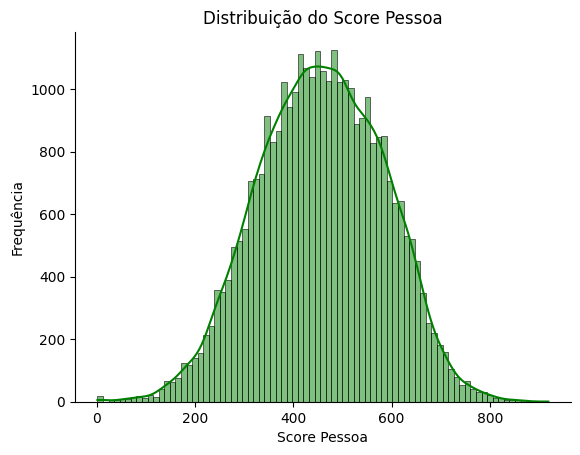

In [26]:
#gráfico de distribuição
sns.histplot(df['Score Pessoa'], kde=True, color='Green')

#gráfico
sns.despine()
plt.xlabel('Score Pessoa')
plt.ylabel('Frequência')
plt.title('Distribuição do Score Pessoa')
plt.show()

In [27]:
#Calcular correlação pearson
correlacoes = df_dummy.corr()['over30_mob3']
correlacoes = correlacoes.drop('over30_mob3')
correlacoes = correlacoes.abs().sort_values(ascending=False)

print(correlacoes)

Score Pessoa                           0.194500
Tipo de cliente_4                      0.088326
Tipo de cliente_2                      0.070397
Tempo até utilização_61 - 90 dias      0.047880
Renda                                  0.047697
                                         ...   
Tempo até utilização_301 - 330 dias    0.000554
Hora da compra_15                      0.000502
Tempo até utilização_271 - 300 dias    0.000475
provedor_email_msn                     0.000123
Hora da compra_4                       0.000012
Name: over30_mob3, Length: 810, dtype: float64


In [28]:
#Função para calcular o coeficiente de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

#Calcular o coeficiente de Cramér para todas as variáveis
correlacoes_cramer = {}
for coluna in df_dummy.columns:
    if coluna != 'over30_mob3':
        coef_cramer = cramers_v(df_dummy['over30_mob3'], df_dummy[coluna])
        correlacoes_cramer[coluna] = coef_cramer

correlacoes_cramer = pd.Series(correlacoes_cramer, name='Coeficiente de Cramér')
correlacoes_cramer = correlacoes_cramer.abs().sort_values(ascending=False)

print(correlacoes_cramer)


Score Pessoa                     0.211912
Tipo de cliente_4                0.088049
Score Email                      0.079762
idade_cliente                    0.077916
Tipo de cliente_2                0.070009
                                   ...   
provedor_email_gestaopublica     0.000000
provedor_email_gfmaquinas        0.000000
provedor_email_gfwtransportes    0.000000
provedor_email_ggedesign         0.000000
provedor_email_lasalle           0.000000
Name: Coeficiente de Cramér, Length: 810, dtype: float64


In [29]:
#criando um DataFrame para armazenar as correlações de bisserial ponto
correlacoes_pb = pd.DataFrame(columns=['variavel', 'correlacao'])

#Iterar sobre as colunas do DataFrame
for coluna in df_dummy.columns:
    if coluna != 'over30_mob3':
        corr, _ = pointbiserialr(df_dummy['over30_mob3'], df_dummy[coluna])
        correlacoes_pb = correlacoes_pb.append({'variavel': coluna, 'correlacao': corr}, ignore_index=True)

#Ordenando o DataFrame em ordem decrescente da magnitude correlação
correlacoes_pb = correlacoes_pb.sort_values(by='correlacao', key=abs, ascending=False)

print(correlacoes_pb)

                                variavel  correlacao
7                           Score Pessoa   -0.194500
33                     Tipo de cliente_4   -0.088326
31                     Tipo de cliente_2    0.070397
46     Tempo até utilização_61 - 90 dias   -0.047880
5                                  Renda   -0.047697
..                                   ...         ...
41   Tempo até utilização_301 - 330 dias    0.000554
22                     Hora da compra_15   -0.000502
40   Tempo até utilização_271 - 300 dias   -0.000475
480                   provedor_email_msn   -0.000123
11                      Hora da compra_4   -0.000012

[810 rows x 2 columns]


**Tratamento de dados**

In [2]:
#Coluna e-mail
contagem_provedores = df['provedor_email'].value_counts()

#exibir a lista com contagens
i = 1
for provedor, quantidade in contagem_provedores.items():
    print(f'{i} - {provedor}: {quantidade}')
    i = i+1

#Lista de provedores a serem mantidos (mais frequentes)
provedores = ['gmail', 'hotmail', 'yahoo', 'outlook', 'icloud', 'live', 'bol', 'uol', 'terra']

#Criando uma condicional para deixar como "Outros" os emails pouco frequentes
df['provedor_email'] = df['provedor_email'].apply(lambda x: x if x in provedores else 'outros')

#Dados apresentam 731 provedores, sendo a maioria com poucos dados. Nessa etapa, foram agrupados os provedores menos relevantes.

In [31]:
#criacao de variavel comprometimento: Avalir participacao do valor da compra na renda da pessoa
df['comprometimento_renda'] = df['valor_compra'] / df['Renda']

**Pipeline - ML**

Etapa para teste de diversos modelos de ML, utilizando Pipeline. Necessário para avaliar performance dos modelos, antes de escolher um em específico.

In [32]:
#Separar as variáveis X e y
X = df_dummy.drop(columns=['over30_mob3'])
y = df_dummy['over30_mob3']

#Separar em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Separar em conjunto de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#Criar uma instância do RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

#Aplicar oversampling aos conjuntos
X_train, y_train = ros.fit_resample(X_train, y_train)
X_val, y_val = ros.fit_resample(X_train, y_train)

#Criar uma lista de modelos
models = [
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ('Logistic Regression', LogisticRegression()),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Gaussian NB', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Bagging', BaggingClassifier()),
    ('Extra Trees', ExtraTreesClassifier()),
    ('Quadratic Discriminant Analysis', QuadraticDiscriminantAnalysis()),
    ('XGBoost', XGBClassifier(verbose=False)),
    ('LightGBM', LGBMClassifier())
]

#Loop através dos modelos
for model_name, model in models:

    print(f'Model: {model_name}')

    #Criar pipeline com pré-processamento usando StandardScaler (corrigir escala)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
     
    #treinar o pipeline
    pipeline.fit(X_train, y_train)

    #fazer predicoes no conjunto de teste
    previsoes = pipeline.predict(X_test)

    #Calcular métricas
    acuracia = accuracy_score(y_test, previsoes)
    recall = recall_score(y_test, previsoes)
    acuracia_bal = balanced_accuracy_score(y_test, previsoes)
    precisao, recall_bal, f1, suporte = precision_recall_fscore_support(y_test, previsoes, average='binary')
    auc = roc_auc_score(y_test, previsoes)


    #Exibir métricas balanceadas
    print(f'Acurácia: {acuracia}')
    print(f'Recall: {recall}')
    print(f'Acurácia Balanceada: {acuracia_bal}')
    print(f'Precisão Balanceada: {precisao}')
    print(f'Recall Balanceado: {recall_bal}')
    print(f'F1-Score Balanceado: {f1}')
    print(f'AUC: {auc}')

    #divisor
    print('-' * 30)

Model: Random Forest
Acurácia: 0.8721266555031207
Recall: 0.0194884287454324
Acurácia Balanceada: 0.5066996771423752
Precisão Balanceada: 0.3137254901960784
Recall Balanceado: 0.0194884287454324
F1-Score Balanceado: 0.03669724770642202
AUC: 0.5066996771423753
------------------------------
Model: Gradient Boosting
Acurácia: 0.6428680164408586
Recall: 0.6492082825822169
Acurácia Balanceada: 0.6455853521470583
Precisão Balanceada: 0.20571208027788498
Recall Balanceado: 0.6492082825822169
F1-Score Balanceado: 0.31242672919109027
AUC: 0.6455853521470584
------------------------------
Model: SVM
Acurácia: 0.6526107474501446
Recall: 0.6285018270401949
Acurácia Balanceada: 0.6422780533948365
Precisão Balanceada: 0.2069795427196149
Recall Balanceado: 0.6285018270401949
F1-Score Balanceado: 0.31140615570307784
AUC: 0.6422780533948366
------------------------------
Model: Logistic Regression
Acurácia: 0.6462170802253007
Recall: 0.6528623629719854
Acurácia Balanceada: 0.6490651411241277
Precisão 

**CatBoost**

CatBoost performou bem e decidi utiliza-lo, rodando separado. Aproveitando a capacidade nativa do CatBoost de trabalhar com dados desbalanceados e também com variáveis categóricas.

• Desempenho: CatBoost foi o modelo com melhor recall e acurácia balanceada, muito próximo ao 
modelo de redes neurais e demais baseados em árvores de decisão.

• Dados desbalanceados: O modelo tem o seu próprio parâmetro para tratar com dados 
desbalanceados, que é o caso deste estudo.

• Variáveis categóricas: Uma das principais vantagens é que o CatBoost consegue trabalhar de forma 
eficiente com variáveis categóricas, sem necessidade de transformações nos dados.

• Entendimento do modelo: O modelo de Árvore de decisão (base do gradient CatBoost) é 
relativamente simples de entender, em relação a redes neurais. Podemos usar o shap para entender 
as relações entre a variável resposta e as features.


In [33]:
#Separar as variaveis x e y
X = df.drop(columns=['over30_mob3'])
y = df['over30_mob3']

#lista de colunas categoricas
colunas_cat = ['Tipo de cliente','Tempo até utilização','Hora da compra',
           'risco_validador','provedor_email','uf']

#separar em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#separar em conjunto de treinamento e validação
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#calcular os pesos de classe inversamente proporcionais as frequências
class_weights = len(y_train) / (2 * np.bincount(y_train))

#dicionário de pesos de classe
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

#model parametros
model = CatBoostClassifier(iterations=200, depth=7, cat_features=colunas_cat,
            class_weights=class_weights_dict, random_state=42, verbose=False)

#Treinar o modelo
model.fit(X_train, y_train,eval_set=(X_val, y_val))


In [34]:
#Fazer previsões no conjunto de teste
previsoes = model.predict(X_test)

#Calcular métricas
acuracia = accuracy_score(y_test, previsoes)
recall = recall_score(y_test, previsoes)
acuracia_bal = balanced_accuracy_score(y_test, previsoes)
precisao, recall_bal, f1, suporte = precision_recall_fscore_support(y_test, previsoes, average='binary')
auc = roc_auc_score(y_test, previsoes)

#Exibir métricas
print(f'Acurácia: {acuracia}')
print(f'Recall: {recall}')
print(f'Acurácia Balanceada: {acuracia_bal}')
print(f'Precisão Balanceada: {precisao}')
print(f'Recall Balanceado: {recall_bal}')
print(f'F1-Score Balanceado: {f1}')
print(f'AUC: {auc}')

#report de classificacao
report = classification_report(y_test, previsoes)
print(report)

Acurácia: 0.6542852793423657
Recall: 0.6467722289890377
Acurácia Balanceada: 0.651065307257219
Precisão Balanceada: 0.21138535031847133
Recall Balanceado: 0.6467722289890377
F1-Score Balanceado: 0.3186318631863186
AUC: 0.651065307257219
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      5748
           1       0.21      0.65      0.32       821

    accuracy                           0.65      6569
   macro avg       0.57      0.65      0.54      6569
weighted avg       0.84      0.65      0.71      6569



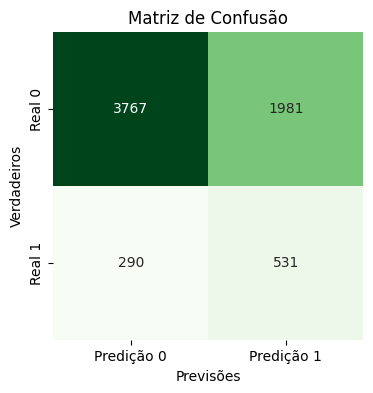

In [35]:
#calcular a matriz de confusão
cm = confusion_matrix(y_test, previsoes)

#plotar a matriz de confusão
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predição 0', 'Predição 1'],
            yticklabels=['Real 0', 'Real 1'])

plt.xlabel('Previsões')
plt.ylabel('Verdadeiros')
plt.title('Matriz de Confusão')
plt.show()

• Modelo balanceado x desbalanceado: apesar do modelo com dados desbalanceados ter uma acurácia de 0.88, foi
preferível o modelo balanceado, devido as demais métricas, como recall (0.006 x 0.65) e todas as outras serem muito
superiores. Considerou-se fundamental nesse modelo de crédito possuir um bom recall e AUC. A não identificação de não
pagadores pode gerar prejuízos para a empresa.

**Shap**

Shap para avaliar resultados do modelo. Como ele determina os resultados?

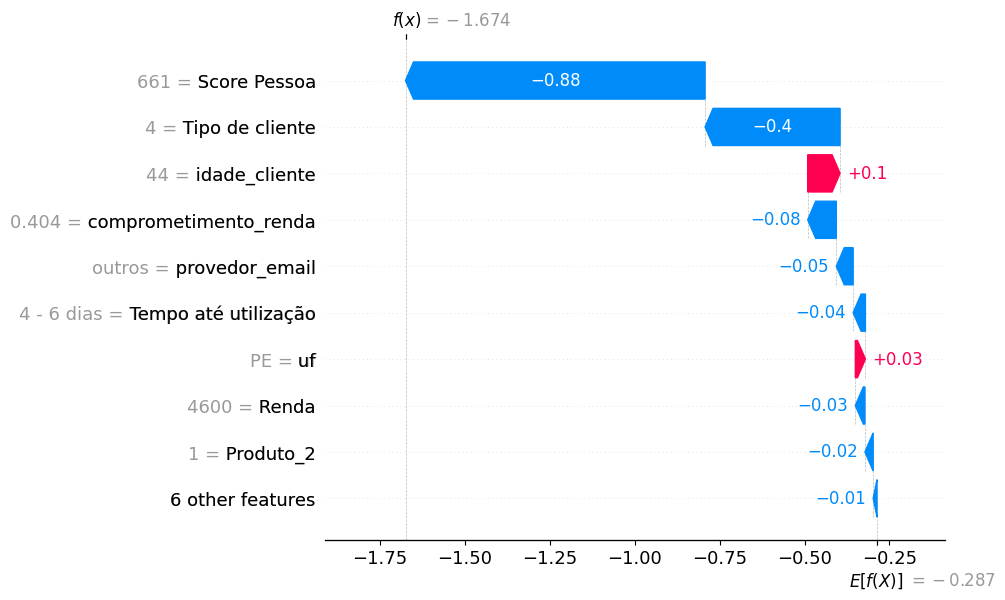

In [36]:
#JavaScript necessária
shap.initjs()

#dados shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

#grafico
shap.plots.waterfall(shap_values[1])

In [37]:
#Motivadores
shap.plots.force(shap_values[1])

In [38]:
#visualizar todas as predicoes
shap.plots.force(shap_values[:500])

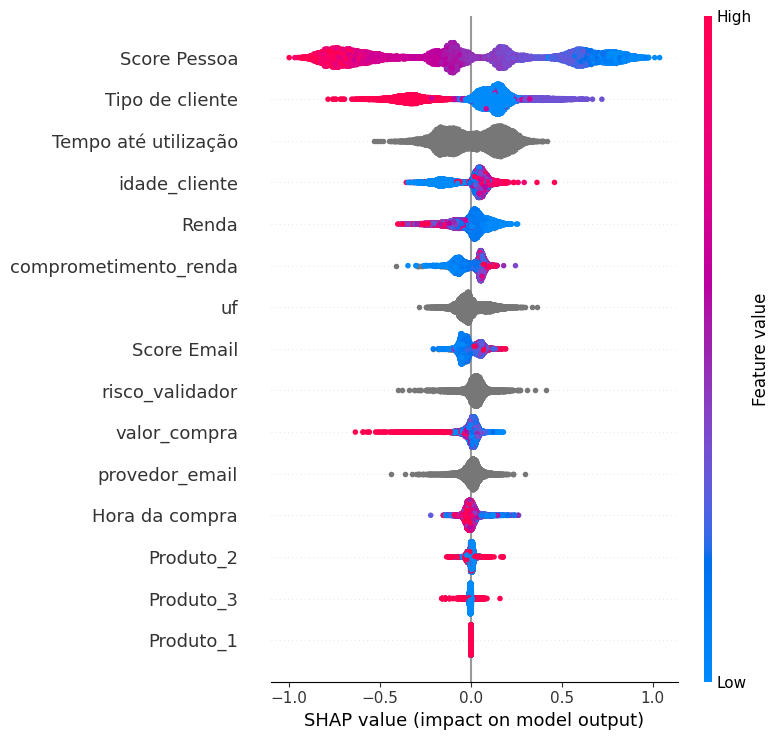

In [39]:
#grafico
shap.summary_plot(shap_values, X_train)

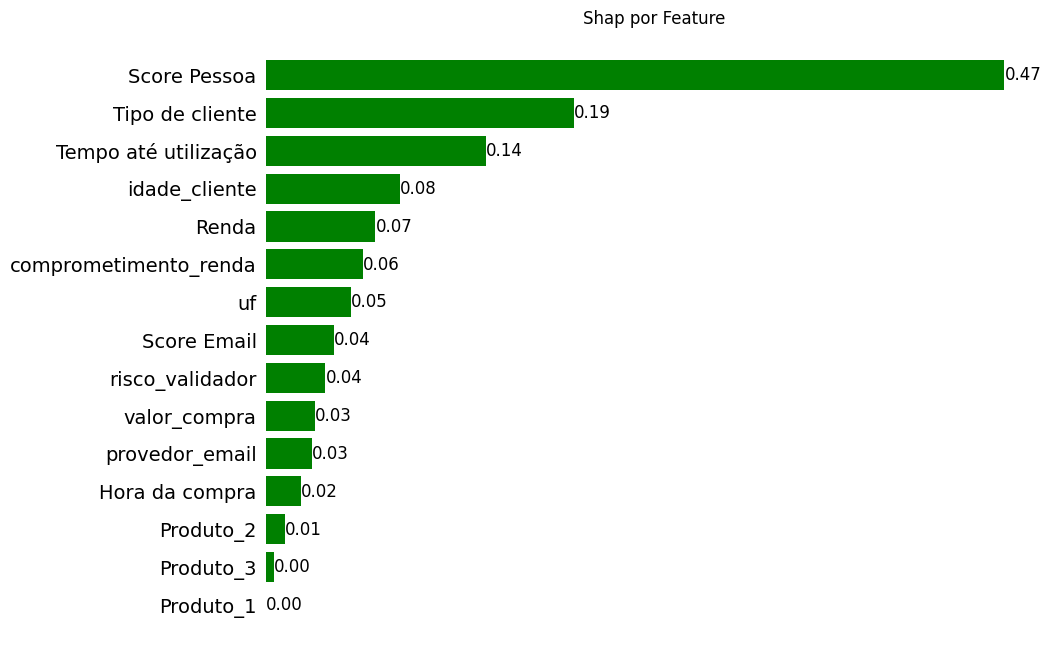

In [40]:
#colunas
feature = X_train.columns.tolist() 

#shap values
shap_values_inverted = np.where(shap_values.values > 0, shap_values.values, -shap_values.values)
sorted_indices = np.argsort(shap_values_inverted.mean(axis=0))[::1]

#ordenacao
sort_feature = [feature[i] for i in sorted_indices]
sort_shap = shap_values_inverted.mean(axis=0)[sorted_indices]

#config plot
fig, ax = plt.subplots(figsize=(10, 8)) #tamanho
bars = ax.barh(sort_feature, sort_shap, color='green', height=0.8) #barras
ax.set_title('Shap por Feature') #titulo
for index, valor in enumerate(sort_shap):
    ax.text(valor, index, f'{valor:.2f}', ha='left', va='center', color='black', fontsize=12) #rotulos
for spine in ax.spines.values():
    spine.set_visible(False) #bordas
ax.xaxis.set_visible(False) #eixo x
ax.tick_params(axis='y', which='both', left=False, labelsize=14) #eixo x 

#exibir
plt.show()

**Variáveis Categóricas**

Shap não trabalha tão bem com as variáveis categóricas (quando não são dummy). Realizando análise extra para entender relação do Over com as variáveis categóricas com maior valor shap.

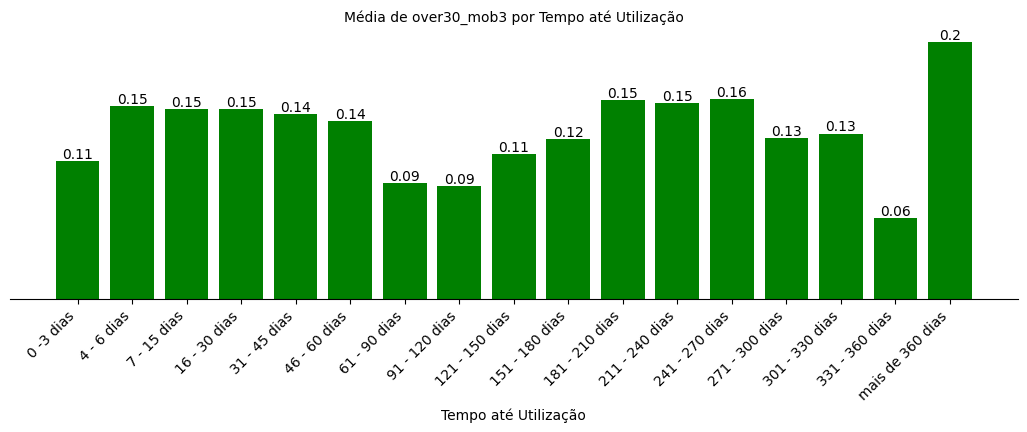

In [41]:
utilizacao = df

#ordenacao
order = [
    '0 -3 dias', '4 - 6 dias', '7 - 15 dias', '16 - 30 dias', '31 - 45 dias',
    '46 - 60 dias', '61 - 90 dias', '91 - 120 dias', '121 - 150 dias',
    '151 - 180 dias', '181 - 210 dias', '211 - 240 dias', '241 - 270 dias',
    '271 - 300 dias', '301 - 330 dias', '331 - 360 dias', 'mais de 360 dias']
utilizacao['Tempo até utilização'] = pd.Categorical(utilizacao['Tempo até utilização'], categories=order, ordered=True)

#calcular media
grouped_data = utilizacao.groupby('Tempo até utilização')['over30_mob3'].mean().reset_index()

#tamanho
plt.figure(figsize=(13, 3.5))

#bars
bars = plt.bar(grouped_data['Tempo até utilização'], grouped_data['over30_mob3'], color='green', width=0.8)

#rótulos aos dados
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10)

#config
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.yticks([])
plt.xlabel('Tempo até Utilização', fontsize=10)
plt.title('Média de over30_mob3 por Tempo até Utilização',fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.show()

• Não há padrão linear. Entretanto observamos alguns itens bastante foras do padrão, 
por exemplo 331 – 360 dias e mais de 360 dias.

In [42]:
#listar ufs
uf = df.groupby('uf')['over30_mob3'].mean().sort_values(ascending=False)

#Transformar a Série um DataFrame
uf = uf.reset_index(name='over30_mob3_mean')

#exibir
uf.head()

,uf,over30_mob3_mean
0,RR,0.224138
1,RN,0.218750
2,AC,0.210526
3,PI,0.193182
4,AL,0.184615


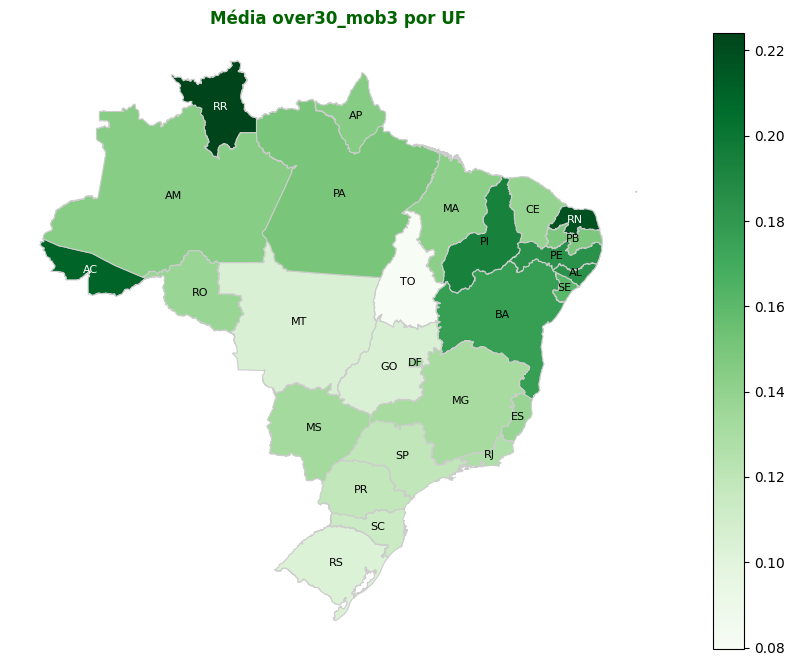

In [43]:
#URL do GeoJSON contendo geometrias dos estados brasileiros
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'

#Baixar o GeoJSON
response = requests.get(url)
data = response.json()

#GeoDataFrame a partir do GeoJSON
gdf_states = gpd.GeoDataFrame.from_features(data['features'])

#mesclar os dados com as geometrias dos estados
gdf = gdf_states.merge(uf, left_on='sigla', right_on='uf')

#grafico
fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(column='over30_mob3_mean', cmap='Greens', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

for x, y, label,over30_mean in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['uf'],gdf['over30_mob3_mean']):
    font_color = 'white' if over30_mean > 0.20 else 'black'
    ax.text(x, y, label, fontsize=8, ha='center', va='center',color=font_color)

#bordas
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])

#titulo
plt.title('Média over30_mob3 por UF',color='#006400', weight='bold')

#exibir
plt.show()

• Estados Norte/Nordeste com 
maiores Over30.

• Estados Centro
-Oeste e Sul 
com menores Over30.

**CatBoost desbalanceado**



In [50]:
#Separar as variaveis x e y
X = df.drop(columns=['over30_mob3'])
y = df['over30_mob3']

#treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
model = CatBoostClassifier(iterations=200, depth=7, cat_features=colunas_cat, random_state=42, verbose=False)
model.fit(X_train, y_train,eval_set=(X_val, y_val))

In [51]:
#Fazer previsões no conjunto de teste
previsoes = model.predict(X_test)

#Calcular métricas
acuracia = accuracy_score(y_test, previsoes)
recall = recall_score(y_test, previsoes)
acuracia_bal = balanced_accuracy_score(y_test, previsoes)
precisao, recall_bal, f1, suporte = precision_recall_fscore_support(y_test, previsoes, average='binary')
auc = roc_auc_score(y_test, previsoes)


#Exibir métricas
print(f'Acurácia: {acuracia}')
print(f'Recall: {recall}')
print(f'Acurácia Balanceada: {acuracia_bal}')
print(f'Precisão Balanceada: {precisao}')
print(f'Recall Balanceado: {recall_bal}')
print(f'F1-Score Balanceado: {f1}')
print(f'AUC: {auc}')

#report de classificacao
report = classification_report(y_test, previsoes)
print(report)

Acurácia: 0.8751712589435227
Recall: 0.0060901339829476245
Acurácia Balanceada: 0.5026971198794349
Precisão Balanceada: 0.5555555555555556
Recall Balanceado: 0.0060901339829476245
F1-Score Balanceado: 0.012048192771084336
AUC: 0.5026971198794348
              precision    recall  f1-score   support

           0       0.88      1.00      0.93      5748
           1       0.56      0.01      0.01       821

    accuracy                           0.88      6569
   macro avg       0.72      0.50      0.47      6569
weighted avg       0.84      0.88      0.82      6569



**Redes Neurais**

Testando aqui também o modelo de Redes Neurais. Desempenho bastante próximo ao CatBoost.

In [48]:
#Separar as variáveis X e y
X = df_dummy.drop(columns=['over30_mob3'])
y = df_dummy['over30_mob3']

#Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Criar uma instância RandomOverSampler
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

#Aplicar oversampling ao conjunto de treinamento
X_train, y_train = ros.fit_resample(X_train, y_train)
X_val, y_val = ros.fit_resample(X_val, y_val)

#Padronizar os dados 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

#modelo RN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(258, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

#Compilar
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

#Treinamento
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_data=(X_val, y_val))

#previsões
predictions = model.predict(X_test)

#Converter probabilidades para binário
predictions = (predictions > 0.5).astype(int)

#Calcular métricas
acuracia = accuracy_score(y_test, predictions)
recall = recall_score(y_test, predictions)
acuracia_bal = balanced_accuracy_score(y_test, predictions)
precisao, recall_bal, f1, suporte = precision_recall_fscore_support(y_test, predictions, average='binary')
auc = roc_auc_score(y_test, predictions)

#Exibir métricas
print(f'Acurácia: {acuracia}')
print(f'Recall: {recall}')
print(f'Acurácia Balanceada: {acuracia_bal}')
print(f'Precisão Balanceada: {precisao}')
print(f'Recall Balanceado: {recall_bal}')
print(f'F1-Score Balanceado: {f1}')
print(f'AUC: {auc}')

206/206 [==============================] - 1s 3ms/step
Acurácia: 0.682143400822043
Recall: 0.607795371498173
Acurácia Balanceada: 0.6502790357838812
Precisão Balanceada: 0.22030905077262694
Recall Balanceado: 0.607795371498173
F1-Score Balanceado: 0.3233959818535321
AUC: 0.6502790357838811


**Considerações finais**

• Efetividade do modelo: baixa acurácia. Utilização do recall como medida para definição de modelo mais 
adequado. Catboost foi o modelo considerado mais adequado.

• Baixa qualidade dos dados de treinamento.

• Necessidade de buscar novas variáveis que expliquem o over30.

• Processos de limpeza de dados: desbalanceamento e variáveis categóricas.

• Resultado, variáveis mais relevantes: Score Pessoa, Idade, Tipo de Cliente, 
comprometimento_renda, Tempo até utilização e UF.